# Modeling Criticality and Avalanche Detection in Wilson-Cowan Networks with Neurolib

## Based on: "Bistability and criticality in the stochastic Wilson-Cowan model" by Hanieh Alvankar Golpayegan and Antonio de Candia, Phys. Rev. E 107, 034404 (2023)

This document explores how criticality in the Wilson-Cowan model emerges from a **stochastic version** with a **superlinear response function**. This leads to **bistability** between a low-activity critical state and a high-activity supercritical state. To model criticality (specifically the low-activity, power-law avalanche regime) using `neurolib`'s Wilson-Cowan model, the following parameters are key:

---

### Key Modified Parameters in the `neurolib` Wilson-Cowan Model

Below, we detail the essential parameters that we have modified to replicate the critical dynamics proposed in the article, along with their justification and adjusted values:

#### 1. `tau_exc`, `tau_inh` (Deactivation Rates)

* **Description:** Define the intrinsic timescales of neuronal deactivation, fundamental to system dynamics.
* **Justification:** Alignment with the time constants used in the stochastic model from the article.
* **Modified Values:**
    * `tau_exc = 0.1` ms⁻¹
    * `tau_inh = 0.1` ms⁻¹
* **Reference:** Section II, Model.

#### 2. Custom Activation Function with `beta_val` and `gamma_val` (Superlinearity)

* **Description:** The article proposes an activation function `f(s) = beta * tanh(s + gamma * s^2)` for `s > 0`, which introduces crucial superlinearity. The parameters `beta_val` and `gamma_val` control the shape of this function.
* **Justification:** A `gamma > 0` is **essential** for the emergence of bistability (coexistence of low- and high-activity states) and for criticality to arise from a first-order phase transition. The standard `neurolib` sigmoid does not achieve this effect directly.
* **Modified Values:**
    * `beta_val = 0.1` ms⁻¹ (`beta` value in the `tanh` function)
    * `gamma_val = 3.0` (this value, typically `gamma >= 2.33`, ensures the necessary bistability for criticality, see Fig. 3 of the article)
* **Implementation in `neurolib`:** We have **directly modified the `timeIntegration.py` file** to implement this custom activation function `f(s) = beta * tanh(s + gamma * s^2)`. The parameters `beta_val` and `gamma_val` have been added and are managed through the `params` dictionary in `loadDefaultParams.py`, replacing the role previously held by `a_exc`, `a_inh`, `mu_exc`, and `mu_inh` in shaping the activation curve.

#### 3. `exc_ext` (External Excitatory Input / `h`)

* **Description:** Represents the external drive to the system.
* **Justification:** Criticality (low-activity state) is found with minimal external input, allowing intrinsic fluctuations to drive bursts of activity. This parameter is varied to explore the dynamic regimes (subcritical, critical, hypercritical) within the bistability region.
* **Modified Values (examples for regimes):**
    * `Subcritical`: `0.30`
    * `Critical`: `0.000001` (very close to zero)
    * `Hypercritical`: `0.90`
* **Reference:** Section II, Model.

#### 4. `c_excexc`, `c_inhexc` (Intrinsic Connectivity Weights / `w_E`, `w_I`)

* **Description:** These parameters define the balance between excitation and inhibition within each node (`w_0 = w_E - w_I`), determining its intrinsic stability and positioning the system on the "critical line."
* **Justification:** The article identifies the critical line (where the low-activity fixed point becomes unstable) at `w_0 = 1`.
* **Modified Values:** Assuming `w_E + w_I = 13.8` (as commonly used in WC models), we have set:
    * `c_excexc = 7.4` (corresponds to `w_E`)
    * `c_inhexc = 6.4` (corresponds to `w_I`)
* **Reference:** Section II, Model (specifically, `w_0 = 1` for $\alpha = \beta = 0.1$).

#### 5. `sigma_ou` (Noise Intensity)

* **Description:** Controls the intensity of the Ornstein-Uhlenbeck process that models the stochastic noise.
* **Justification:** The article uses a *stochastic* WC model. Noise is crucial for the emergence of avalanches and for facilitating transitions between the bistable states.
* **Modified Value:**
    * `sigma_ou = 0.01` (a non-zero value essential for allowing fluctuations and avalanche propagation).
* **Reference:** Section II, Model (Equation 1 for the stochastic formulation).

---

### Criticality Tuning Strategy Summary

1.  **Direct Implementation of `gamma_val` and `beta_val`:** We have directly integrated the superlinear activation function, which is fundamental to critical behavior.
2.  **Specific `exc_ext` Adjustment:** This allows for exploring different regimes (subcritical, critical, hypercritical) by shifting the operating point within the bistable region.
3.  **Adjustment of `c_excexc` and `c_inhexc`:** These have been configured to achieve `w_E - w_I = 1`, establishing the basis for critical behavior.
4.  **Introduction of Noise (`sigma_ou`):** Sufficient noise has been added to permit fluctuations and avalanche propagation.
5.  **Simulation and Verification:** After setting these parameters, it is crucial to run simulations and perform avalanche detection. To verify criticality, plot avalanche size and duration distributions on log-log scales to check for **power-law scaling**, which is the hallmark of critical behavior.

Loading 'hcp' dataset...
'80' channels loaded from 'hcp' dataset.

--- Simulating Regime: Subcritical ---
Binarizing signals per channel...

Generating visualizations for regime: 'Subcritical'...


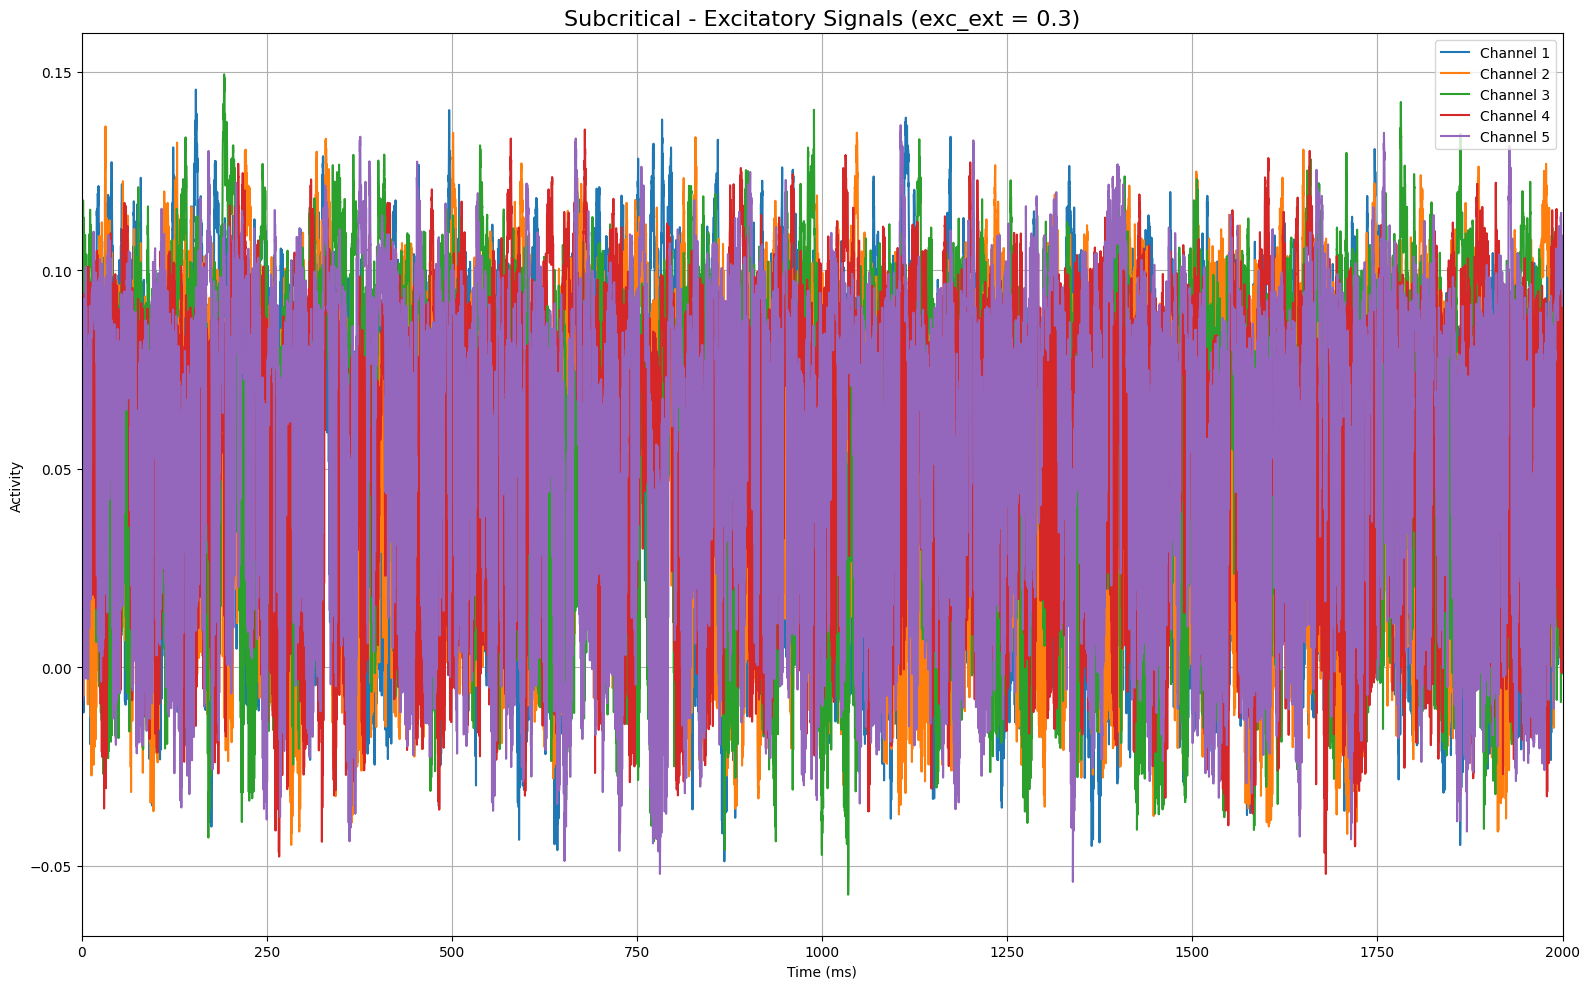

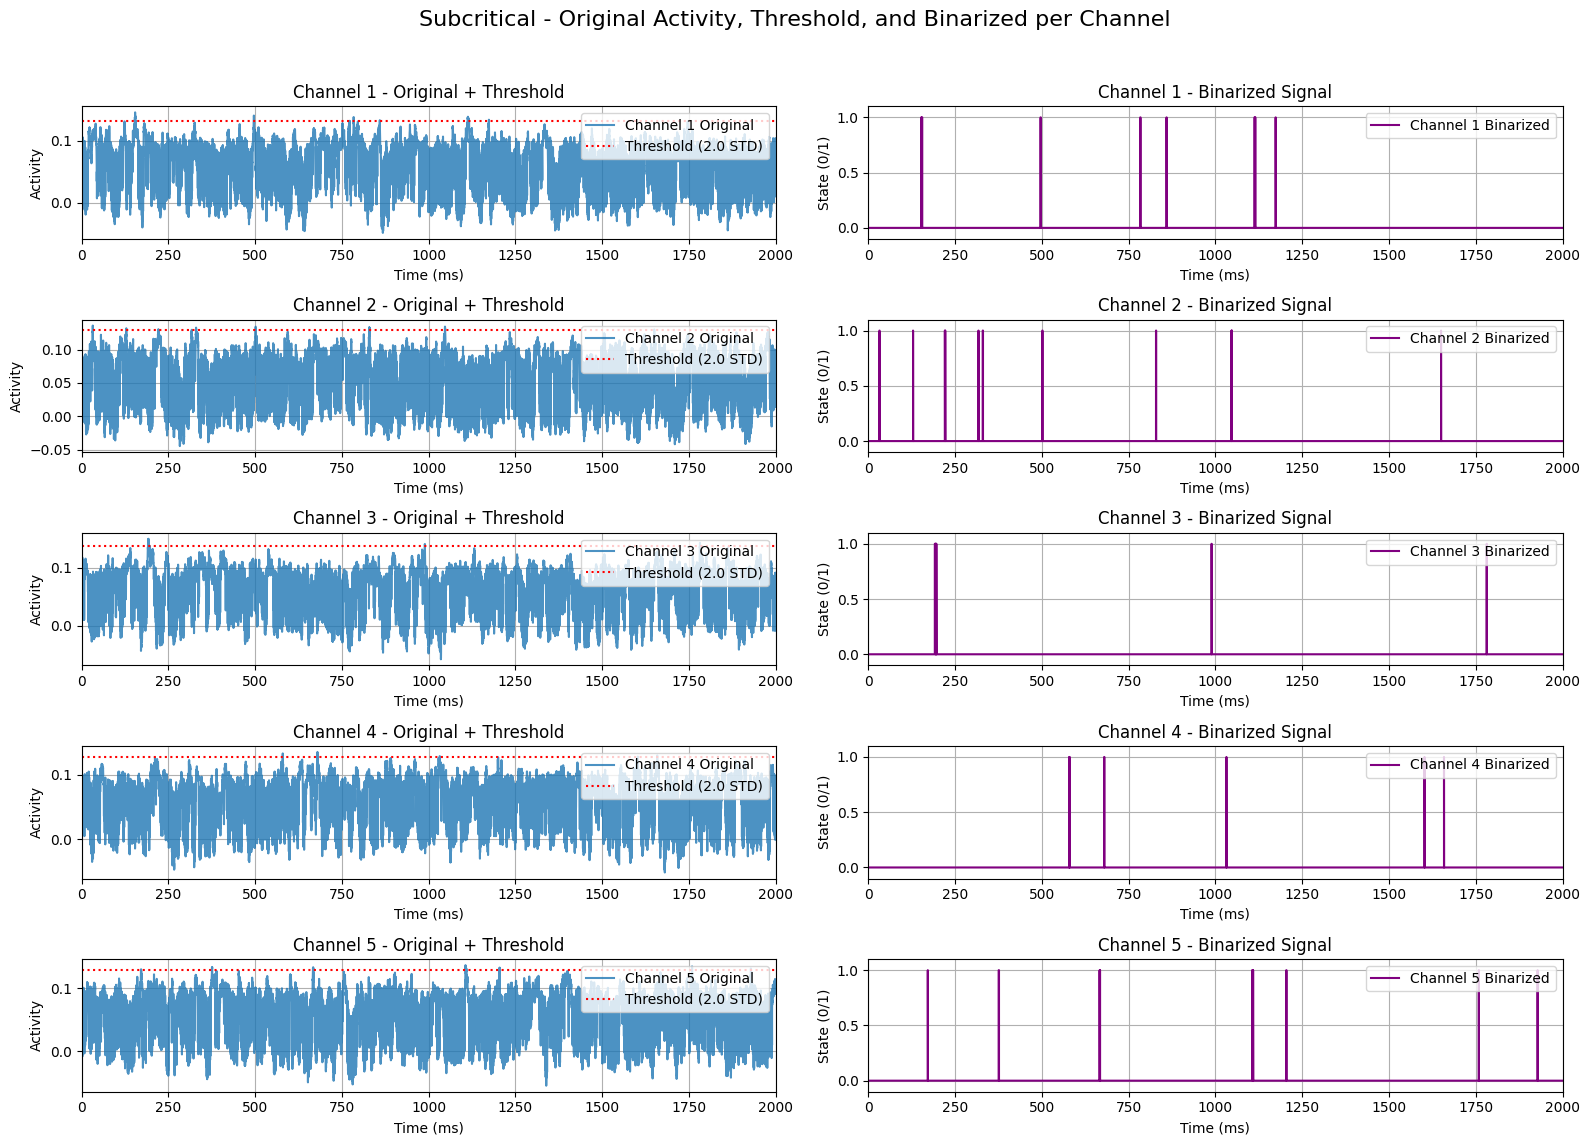


--- Simulating Regime: Critical ---
Binarizing signals per channel...

Generating visualizations for regime: 'Critical'...


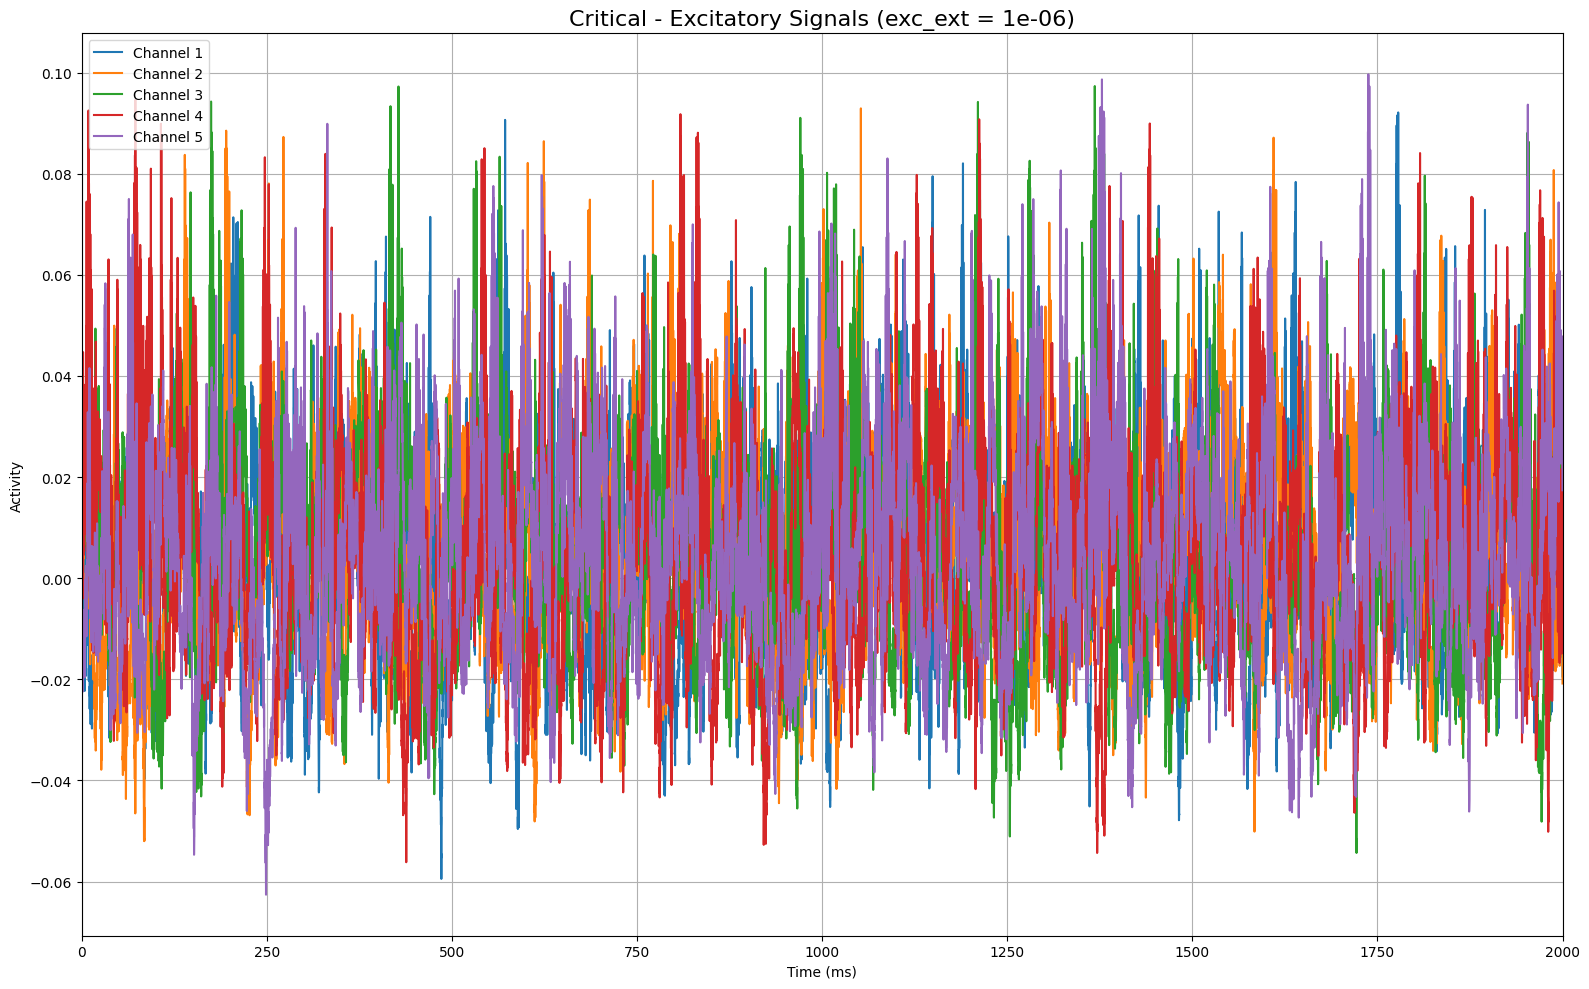

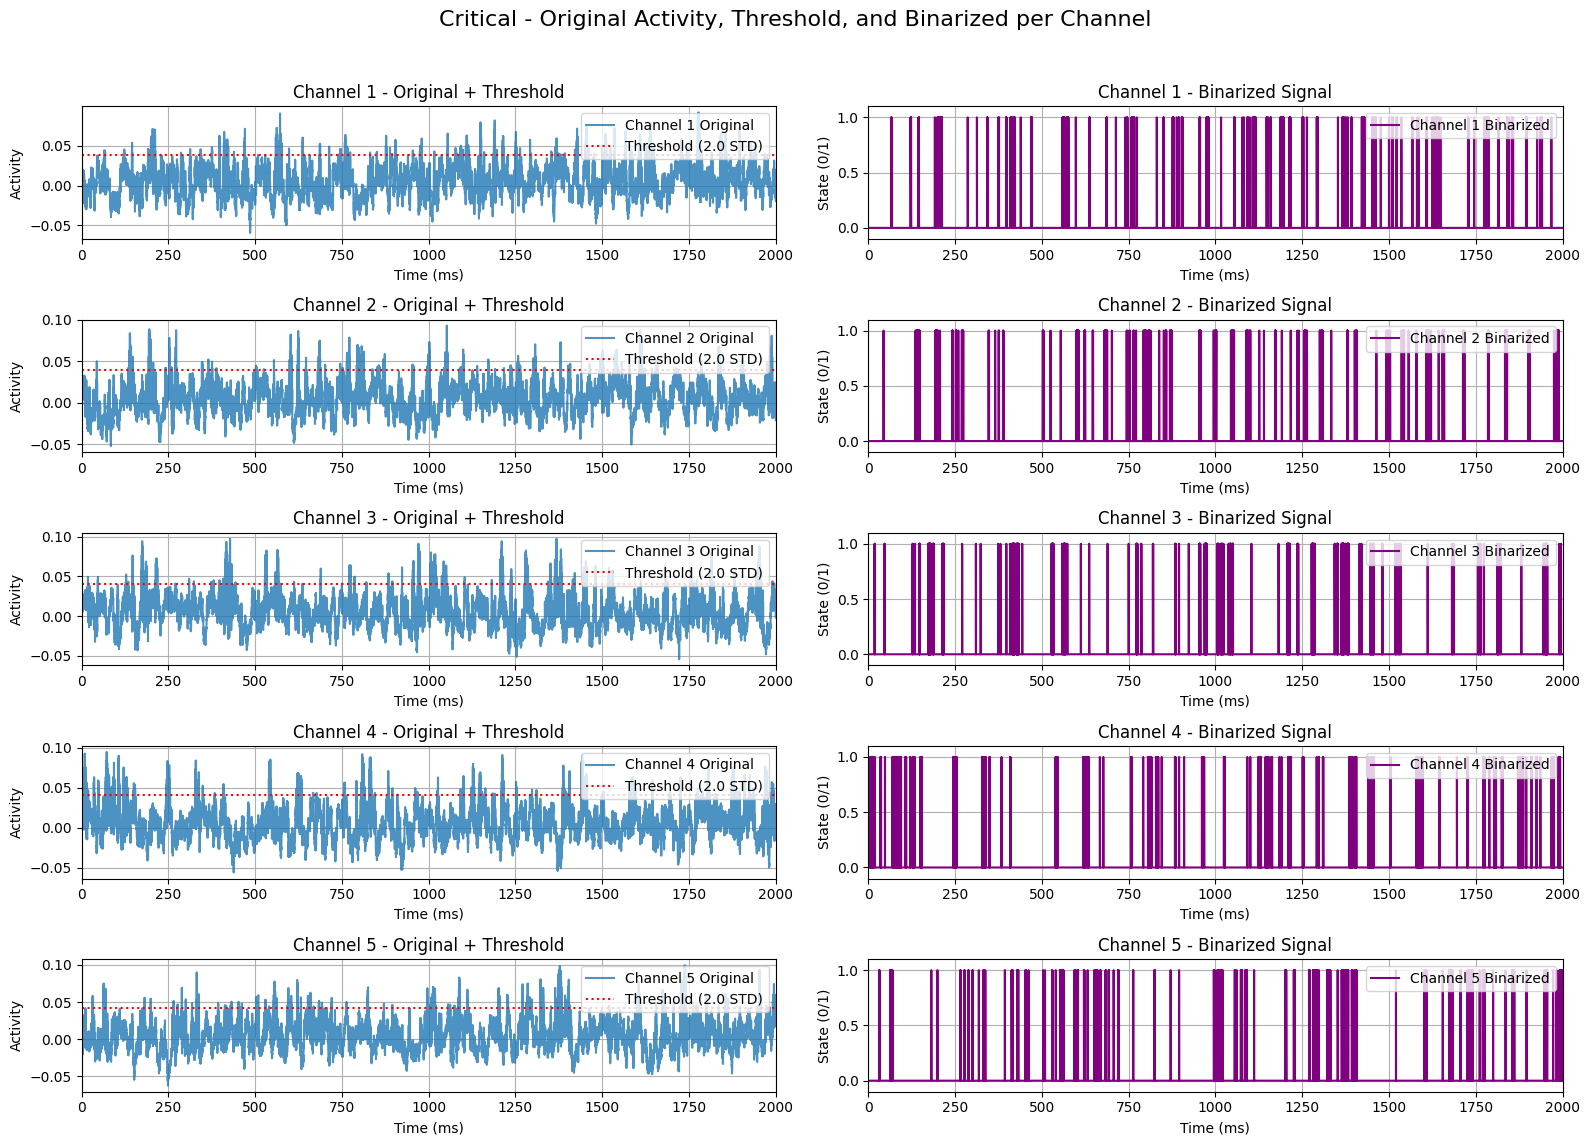


--- Simulating Regime: Hypercritical ---
Binarizing signals per channel...

Generating visualizations for regime: 'Hypercritical'...


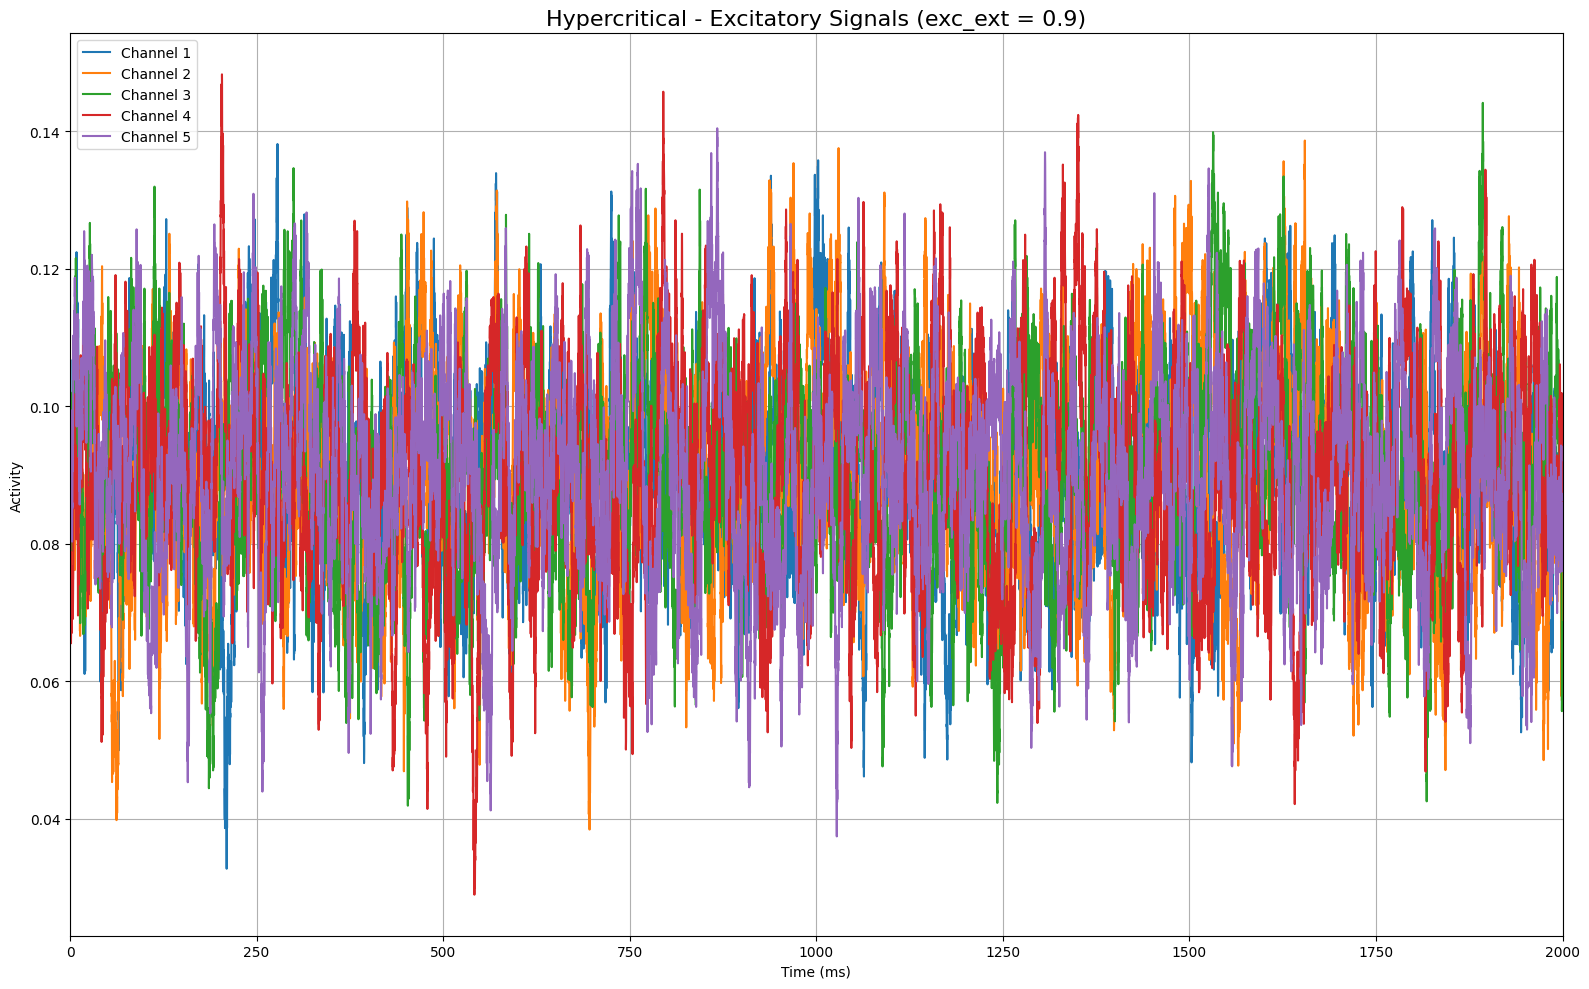

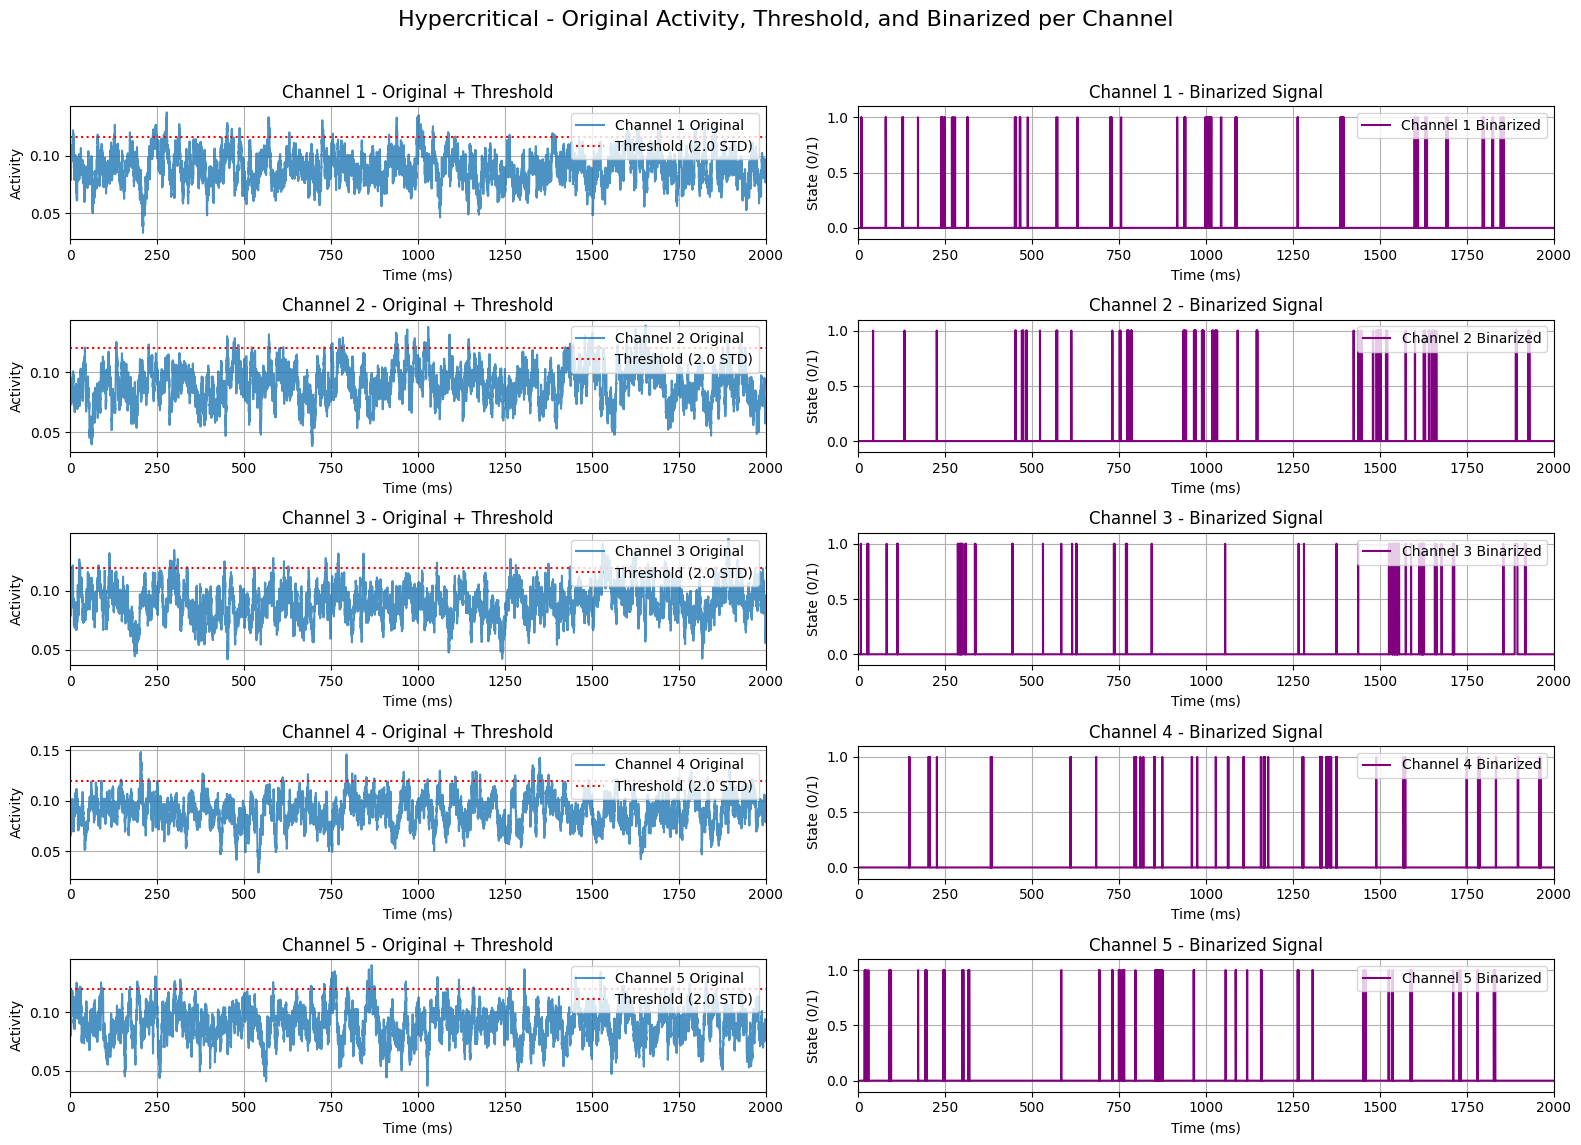


Simulation and visualization for all regimes completed.


In [ ]:
import neurolib.models.wc_criticality as wc # Assuming modified neurolib is in this path
from neurolib.utils.loadData import Dataset
import numpy as np
import matplotlib.pyplot as plt

# IMPORTANT: Ensure your modified 'wc_criticality' package is correctly set up
# in your Python environment or PYTHONPATH for the import to work.

# -------------------------------
# General Configuration
# -------------------------------
duration = 20 * 1000  # 20 seconds
threshold_multiplier = 2.0 # Multiplier for binarization threshold

# Definition of the three dynamic regimes based on external input (exc_ext)
# These values will explore the states given the underlying model parameters
# are set for bistability/criticality as per the paper.
regimes = {
    "Subcritical": 0.30,  # Lower external input, favors low activity (might not show power-law)
    "Critical": 0.000001, # Very low external input, aims for the low-activity critical state
    "Hypercritical": 0.90  # Higher external input, pushes towards high activity (supercritical)
}

# Common Wilson-Cowan model parameters from the Alvankar Golpayegan and de Candia (2023) paper
# These values create the underlying bistable/critical landscape.
paper_derived_params = {
    'tau_exc': 0.1,    # alpha from paper (ms^-1)
    'tau_inh': 0.1,    # alpha from paper (ms^-1)
    'beta_val': 0.1,   # beta from paper's activation function (ms^-1)
    'gamma_val': 3.0,  # gamma from paper (e.g., >=2.33 ensures bistability for criticality)
    
    # These map to w_E and w_I from the paper, assuming w_E - w_I = 1 for the critical line.
    # The paper often uses w_E + w_I = 13.8. So, w_E = 7.4, w_I = 6.4
    'c_excexc': 7.4,   # Corresponds to w_E in the paper for E-E coupling
    'c_inhexc': 6.4,   # Corresponds to w_I in the paper for I-E coupling
    
    # Other internal couplings - use reasonable defaults or values not specified by paper's critical line
    'c_excinh': 15.0,  # Default or common neurolib value
    'c_inhinh': 3.0,   # Default or common neurolib value
    
    'sigma_ou': 0.01,  # Non-zero noise for stochasticity and avalanche emergence
    'K_gl': 0.6,       # Global coupling strength (from default neurolib WC model)
    'signalV': 20.0,   # Signal transmission speed (from default neurolib WC model)
}


# -------------------------------
# Load dataset with Cmat and Dmat
# -------------------------------
print("Loading 'hcp' dataset...")
ds = Dataset("hcp")
Cmat = ds.Cmat
Dmat = ds.Dmat
n_channels = Cmat.shape[0]
print(f"'{n_channels}' channels loaded from 'hcp' dataset.")

# -------------------------------
# Simulation and analysis per regime
# -------------------------------
for regime_name, exc_ext_val in regimes.items():
    print(f"\n--- Simulating Regime: {regime_name} ---")

    # Create model - it will load default params, then we override
    model = wc.WCModel(Cmat=Cmat, Dmat=Dmat)
    
    # Set duration
    model.duration = duration
    
    # Assign parameters derived from the paper's critical setup
    for p_name, p_val in paper_derived_params.items():
        model.params[p_name] = p_val

    # Override exc_ext for the current regime
    model.params['exc_ext'] = exc_ext_val

    model.run()
    time = model.outputs['t']
    exc = model.outputs['exc']  # (n_channels, t)

    # Binarization per channel
    binary_exc = np.zeros_like(exc, dtype=int)
    thresholds_per_channel = []

    print("Binarizing signals per channel...")
    for i in range(n_channels):
        mean_i = np.mean(exc[i])
        std_i = np.std(exc[i])
        threshold = mean_i + threshold_multiplier * std_i
        binary_exc[i] = (exc[i] > threshold).astype(int)
        thresholds_per_channel.append(threshold)

    # -------------------------------
    # Visualization
    # -------------------------------
    channels_to_plot = min(5, n_channels) # Plots a maximum of 5 channels
    plot_xlim_start = 0
    plot_xlim_end = 2000 # Time range for detailed visualization

    print(f"\nGenerating visualizations for regime: '{regime_name}'...")

    # Plot 1: Original excitatory signals
    plt.figure(figsize=(16, 10))
    plt.title(f"{regime_name} - Excitatory Signals (exc_ext = {exc_ext_val})", fontsize=16)
    for i in range(channels_to_plot):
        plt.plot(time, exc[i], label=f"Channel {i+1}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Activity")
    plt.grid(True)
    plt.legend()
    plt.xlim(plot_xlim_start, plot_xlim_end)
    plt.tight_layout()
    plt.show()

    # ---
    # Plot 2: Combination of original signals with thresholds AND binarized signals in subplots per channel
    # ---
    plt.figure(figsize=(16, 12))
    plt.suptitle(f"{regime_name} - Original Activity, Threshold, and Binarized per Channel", fontsize=16)

    for i in range(channels_to_plot):
        # Subplot for original signal and threshold
        plt.subplot(channels_to_plot, 2, 2*i + 1) # Row i, column 1
        plt.plot(time, exc[i], label=f"Channel {i+1} Original", alpha=0.8)
        plt.axhline(y=thresholds_per_channel[i], color='r', linestyle=':', label=f"Threshold ({threshold_multiplier} STD)")
        plt.title(f"Channel {i+1} - Original + Threshold")
        plt.xlabel("Time (ms)")
        plt.ylabel("Activity")
        plt.grid(True)
        plt.legend(loc='upper right')
        plt.xlim(plot_xlim_start, plot_xlim_end)

        # Subplot for binarized signal
        plt.subplot(channels_to_plot, 2, 2*i + 2) # Row i, column 2
        plt.plot(time, binary_exc[i], label=f"Channel {i+1} Binarized", color='purple', drawstyle='steps-post')
        plt.title(f"Channel {i+1} - Binarized Signal")
        plt.xlabel("Time (ms)")
        plt.ylabel("State (0/1)")
        plt.grid(True)
        plt.legend(loc='upper right')
        plt.xlim(plot_xlim_start, plot_xlim_end)
        plt.ylim(-0.1, 1.1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout for the main title
    plt.show()

print("\nSimulation and visualization for all regimes completed.")

# Generating Synthetic Patient Data in Criticality

This Python script is designed to **generate a synthetic dataset of 20 "patients,"** each simulating brain activity in a **critical state**, using a modified version of the Wilson-Cowan model implemented in `neurolib`.

## What are we doing?

1.  **Model Configuration:** We start with the modified Wilson-Cowan model implementation, adjusting its internal parameters (such as deactivation rates, connectivity weights, and crucially, the **superlinear activation function parameters `beta_val` and `gamma_val`**) to align them with the criticality and bistability conditions described in the Alvankar Golpayegan and de Candia (2023) paper. The external input (`exc_ext`) is fixed at a very low value, characteristic of the low-activity critical state.
2.  **Simulación:** For each "patient," the model is simulated for a period of 20 seconds.
3.  **Signal Processing:** From each simulation, the "raw" excitatory activity signal from all 80 channels is extracted. This signal is then "binarized" (converted to 0s and 1s) using an adaptive threshold per channel (mean + 2 * standard deviation).
4.  **Data Saving:** For each patient, a single `.pkl` file is created containing a dictionary. This dictionary holds the raw signal, the binarized signal (both 80 channels), and all the specific parameters used for that patient's simulation. These files are stored in the `../Datos/patients_criticality/` folder.

## How do we ensure distinct individuals?

Although all "patients" are generated under the same model parameters that define the **critical state**, we ensure they are "different" from each other by **varying the random seed (`seed`) for each simulation**.

Since the Wilson-Cowan model operates in its **stochastic version** (incorporating noise), changing the randomness seed produces a different noise realization for each simulation. This, in turn, generates **unique neural activity trajectories and distinct fluctuations** in the signals of each "patient," even when the underlying system dynamics (i.e., its critical state) remain constant. In this way, we obtain 20 distinct examples of systems operating in criticality.

In [5]:
import neurolib.models.wc_criticality as wc  # Assuming your modified neurolib is located here
from neurolib.utils.loadData import Dataset
import numpy as np
import os
import pickle

# --- Configuration ---
NUM_PATIENTS = 20
DURATION = 20 * 1000  # 20 seconds (20000 ms)
THRESHOLD_MULTIPLIER = 2.0 # Multiplier for binarization threshold (for binarization)
OUTPUT_DIR = "../data/patients_criticality" # Ensure this path is correct relative to where you run the script

# Common Wilson-Cowan model parameters from the Alvankar Golpayegan and de Candia (2023) paper
# These values create the underlying bistable/critical landscape.
# Note: exc_ext is set here to the specific value for the *critical* state.
critical_model_params = {
    'tau_exc': 0.1,    # alpha from paper (ms^-1)
    'tau_inh': 0.1,    # alpha from paper (ms^-1)
    'beta_val': 0.1,   # beta from paper's activation function (ms^-1)
    'gamma_val': 3.0,  # gamma from paper (e.g., >=2.33 ensures bistability for criticality)
    
    # These map to w_E and w_I from the paper, assuming w_E - w_I = 1 for the critical line.
    # The paper often uses w_E + w_I = 13.8. So, w_E = 7.4, w_I = 6.4
    'c_excexc': 7.4,   # Corresponds to w_E in the paper for E-E coupling
    'c_inhexc': 6.4,   # Corresponds to w_I in the paper for I-E coupling
    
    # Other internal couplings - use reasonable defaults or values not specified by paper's critical line
    'c_excinh': 15.0,  # Default or common neurolib value
    'c_inhinh': 3.0,   # Default or common neurolib value
    
    'sigma_ou': 0.01,  # Non-zero noise for stochasticity and avalanche emergence
    'K_gl': 0.6,       # Global coupling strength (from default neurolib WC model)
    'signalV': 20.0,   # Signal transmission speed (from default neurolib WC model)
    'exc_ext': 0.000001, # Very low external input, specifically for the low-activity critical state
}

# -------------------------------
# Load dataset with Cmat and Dmat
# -------------------------------
print("Loading 'hcp' dataset...")
ds = Dataset("hcp") # This will download the dataset if not already present
Cmat = ds.Cmat
Dmat = ds.Dmat
n_channels = Cmat.shape[0] # The 'hcp' dataset typically has 80 or more channels
print(f"'{n_channels}' channels loaded from 'hcp' dataset.")

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory '{OUTPUT_DIR}' ensured.")

# -------------------------------
# Generate and Save Patients
# -------------------------------
print(f"Generating {NUM_PATIENTS} patients in critical state...")

for i in range(NUM_PATIENTS):
    print(f"Processing patient {i+1}/{NUM_PATIENTS}...")
    
    # Create model instance
    # Cmat and Dmat are passed directly to initialize the network structure
    model = wc.WCModel(Cmat=Cmat, Dmat=Dmat)
    
    # Set the total simulation duration
    model.duration = DURATION
    
    # Apply all critical parameters derived from the paper
    for p_name, p_val in critical_model_params.items():
        model.params[p_name] = p_val
        
    # Set a unique random seed for each patient.
    # This ensures that each generated signal (due to noise realization and initial conditions)
    # is different, even though the underlying model parameters define the same critical state.
    model.params['seed'] = 1000 + i # Use an offset to ensure distinctness and avoid 0 seed

    # Run the simulation for the current patient
    model.run()
    
    # Extract the raw excitatory signal from the simulation outputs
    exc_raw = model.outputs['exc']  # Shape: (n_channels, time_points)

    # Binarize the signal for each channel independently
    binary_exc = np.zeros_like(exc_raw, dtype=int)
    
    for ch in range(n_channels):
        # Calculate mean and standard deviation for the current channel's raw signal
        mean_ch = np.mean(exc_raw[ch])
        std_ch = np.std(exc_raw[ch])
        
        # Determine the binarization threshold for the current channel
        # This is a common method for binarization in neuroscience (e.g., for avalanche detection)
        threshold_ch = mean_ch + THRESHOLD_MULTIPLIER * std_ch
        
        # Apply the threshold to binarize the signal (0 or 1)
        binary_exc[ch] = (exc_raw[ch] > threshold_ch).astype(int)
            
    # Compile all data for the current patient into a dictionary
    patient_data = {
        'raw_signal': exc_raw,
        'binarized_signal': binary_exc,
        'parameters': model.params.copy() # Store a copy of the exact parameters used for reproducibility
    }
    
    # Define the output filename using f-string for zero-padding (e.g., patient_00.pkl, patient_01.pkl, etc.)
    filename = os.path.join(OUTPUT_DIR, f"patient_{i:02d}.pkl")
    
    # Save the patient data to a pickle file
    with open(filename, 'wb') as f:
        pickle.dump(patient_data, f)
        
    print(f"Patient {i+1} data saved to '{filename}'")

print(f"\nSuccessfully generated and saved {NUM_PATIENTS} patients in the critical state to '{OUTPUT_DIR}'.")

Loading 'hcp' dataset...
'80' channels loaded from 'hcp' dataset.
Output directory '../data/patients_criticality' ensured.
Generating 20 patients in critical state...
Processing patient 1/20...
Patient 1 data saved to '../data/patients_criticality/patient_00.pkl'
Processing patient 2/20...
Patient 2 data saved to '../data/patients_criticality/patient_01.pkl'
Processing patient 3/20...
Patient 3 data saved to '../data/patients_criticality/patient_02.pkl'
Processing patient 4/20...
Patient 4 data saved to '../data/patients_criticality/patient_03.pkl'
Processing patient 5/20...
Patient 5 data saved to '../data/patients_criticality/patient_04.pkl'
Processing patient 6/20...
Patient 6 data saved to '../data/patients_criticality/patient_05.pkl'
Processing patient 7/20...
Patient 7 data saved to '../data/patients_criticality/patient_06.pkl'
Processing patient 8/20...
Patient 8 data saved to '../data/patients_criticality/patient_07.pkl'
Processing patient 9/20...
Patient 9 data saved to '../da